📌 Epoch 1/10: Loss = 0.6926, Accuracy = 27.42%
📌 Epoch 2/10: Loss = 0.6641, Accuracy = 37.21%
📌 Epoch 3/10: Loss = 0.6121, Accuracy = 45.60%
📌 Epoch 4/10: Loss = 0.5646, Accuracy = 53.21%
📌 Epoch 5/10: Loss = 0.5256, Accuracy = 58.35%
📌 Epoch 6/10: Loss = 0.5121, Accuracy = 60.21%
📌 Epoch 7/10: Loss = 0.4888, Accuracy = 63.23%
📌 Epoch 8/10: Loss = 0.4650, Accuracy = 66.88%
📌 Epoch 9/10: Loss = 0.4514, Accuracy = 68.73%
📌 Epoch 10/10: Loss = 0.4427, Accuracy = 69.00%
✅ Student Model Trained & Saved!
📊 Evaluation Results:
+----------------+----------+-------------------+---------+--------------------+---------------+
|    Dataset     | Accuracy |     Precision     |  Recall |      F1 Score      | Learning Rate |
+----------------+----------+-------------------+---------+--------------------+---------------+
|    Test Set    | 63.0625  |  62.8603317848289 | 63.0625 | 61.249018102926925 |     0.001     |
| Validation Set |   60.0   | 59.72829694899643 |   60.0  | 59.36690176208821  |     0

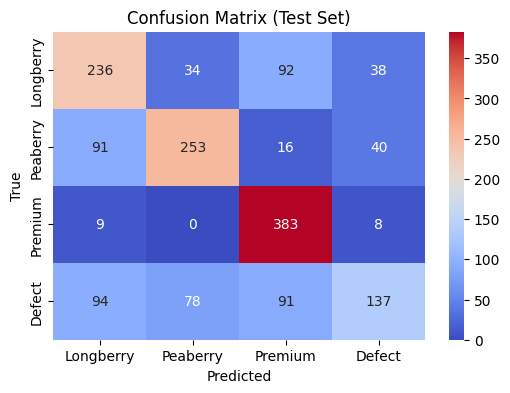

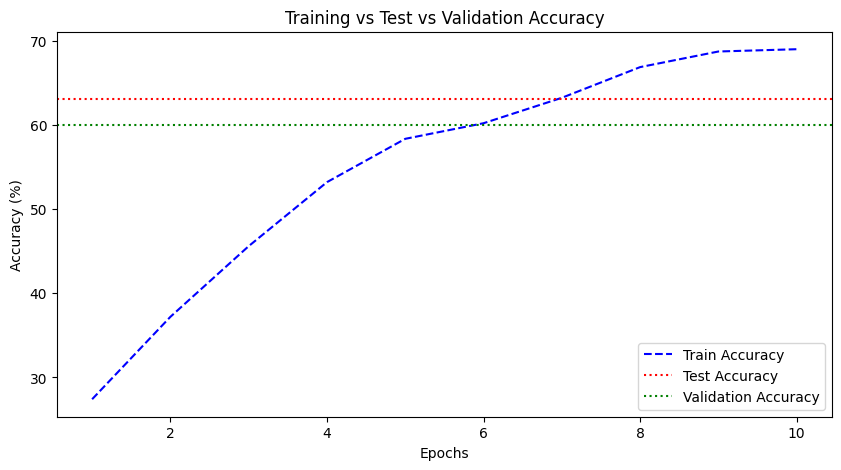

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import torch.nn.utils.prune as prune
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix
import timm
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from tabulate import tabulate
from termcolor import colored
from prettytable import PrettyTable

# Define the Teacher Model (MobileViT)
class TeacherModel(nn.Module):
    def __init__(self):
        super(TeacherModel, self).__init__()
        self.vit = timm.create_model('mobilevit_s', pretrained=True, num_classes=4)

    def forward(self, x):
        return self.vit(x)

# Define the Student Model (Smaller Sparse CNN)
class StudentModel(nn.Module):
    def __init__(self):
        super(StudentModel, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, padding=1)
        self.fc1 = nn.Linear(32 * 8 * 8, 128)
        self.fc2 = nn.Linear(128, 4)  # 4 classes
        self.dropout = nn.Dropout(0.3)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, 2)
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2)
        x = x.view(x.size(0), -1)
        x = self.dropout(F.relu(self.fc1(x)))
        x = self.fc2(x)
        return x

# Define Dataset & DataLoader
transform = transforms.Compose([
    transforms.Resize((32, 32)),
    transforms.ToTensor()
])

dataset_train = datasets.ImageFolder(root="C:\\Users\\user\\Desktop\\CSC YEAR 2\\SEM 2\\MACHINE LEARNING\\dataset3\\USK-Coffee\\train", transform=transform)
train_loader = DataLoader(dataset_train, batch_size=32, shuffle=True)

dataset_test = datasets.ImageFolder(root="C:\\Users\\user\\Desktop\\CSC YEAR 2\\SEM 2\\MACHINE LEARNING\\dataset3\\USK-Coffee\\test", transform=transform)
test_loader = DataLoader(dataset_test, batch_size=32, shuffle=False)

dataset_val = datasets.ImageFolder(root="C:\\Users\\user\\Desktop\\CSC YEAR 2\\SEM 2\\MACHINE LEARNING\\dataset3\\USK-Coffee\\val", transform=transform)
val_loader = DataLoader(dataset_val, batch_size=32, shuffle=False)

# Initialize Models
device = torch.device("cpu")
teacher_model = TeacherModel().to(device)
student_model = StudentModel().to(device)

# Define Loss, Optimizer, and KD Loss
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(student_model.parameters(), lr=0.001)

def kd_loss(student_outputs, teacher_outputs, labels, alpha=0.5, temperature=3.0):
    soft_targets = F.softmax(teacher_outputs / temperature, dim=1)
    soft_loss = F.kl_div(F.log_softmax(student_outputs / temperature, dim=1), soft_targets, reduction='batchmean')
    hard_loss = F.cross_entropy(student_outputs, labels)
    return alpha * soft_loss + (1 - alpha) * hard_loss

# Train Student Model using Knowledge Distillation
def train_student(student, teacher, train_loader, criterion, optimizer, epochs=10):
    teacher.eval()
    student.train()

    train_acc, train_loss = [], []
    
    for epoch in range(epochs):
        running_loss, correct, total = 0.0, 0, 0

        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            with torch.no_grad():
                teacher_outputs = teacher(images)
            
            student_outputs = student(images)
            loss = kd_loss(student_outputs, teacher_outputs, labels)

            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, predicted = torch.max(student_outputs, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)

        epoch_loss = running_loss / len(train_loader)
        epoch_acc = 100 * correct / total

        train_loss.append(epoch_loss)
        train_acc.append(epoch_acc)

        print(colored(f"📌 Epoch {epoch+1}/{epochs}: Loss = {epoch_loss:.4f}, Accuracy = {epoch_acc:.2f}%", "green"))

    torch.save(student.state_dict(), "student_model.pth")
    print(colored("✅ Student Model Trained & Saved!", "blue"))
    return train_loss, train_acc

# Train the Student Model
train_losses, train_accuracies = train_student(student_model, teacher_model, train_loader, criterion, optimizer, epochs=10)

# Evaluate Model
def evaluate_model(model, data_loader, dataset_name):
    model.eval()
    correct, total = 0, 0
    all_preds, all_labels = [], []

    with torch.no_grad():
        for images, labels in data_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    accuracy = accuracy_score(all_labels, all_preds) * 100
    precision = precision_score(all_labels, all_preds, average='weighted') * 100
    recall = recall_score(all_labels, all_preds, average='weighted') * 100
    f1 = f1_score(all_labels, all_preds, average='weighted') * 100

    return accuracy, precision, recall, f1, all_preds, all_labels

# Evaluate on test and validation sets
test_results = evaluate_model(student_model, test_loader, "Test Set")
val_results = evaluate_model(student_model, val_loader, "Validation Set")

# Tabulate Results
table = PrettyTable(["Dataset", "Accuracy", "Precision", "Recall", "F1 Score", "Learning Rate"])
table.add_row(["Test Set", *test_results[:4], "0.001"])
table.add_row(["Validation Set", *val_results[:4], "0.001"])
print(colored("📊 Evaluation Results:", "cyan"))
print(table)

# Confusion Matrix
def plot_confusion_matrix(y_true, y_pred, title):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, fmt="d", cmap="coolwarm", xticklabels=["Longberry", "Peaberry", "Premium", "Defect"], yticklabels=["Longberry", "Peaberry", "Premium", "Defect"])
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title(title)
    plt.show()

plot_confusion_matrix(test_results[5], test_results[4], "Confusion Matrix (Test Set)")

# Plot Metrics
def plot_metrics(train_acc, test_results, val_results):
    epochs = range(1, len(train_acc) + 1)
    test_acc, val_acc = test_results[0], val_results[0]

    plt.figure(figsize=(10, 5))
    plt.plot(epochs, train_acc, label="Train Accuracy", color="blue", linestyle="--")
    plt.axhline(test_acc, label="Test Accuracy", color="red", linestyle=":")
    plt.axhline(val_acc, label="Validation Accuracy", color="green", linestyle=":")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy (%)")
    plt.title("Training vs Test vs Validation Accuracy")
    plt.legend()
    plt.show()

plot_metrics(train_accuracies, test_results, val_results)
